In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load the CSV file to inspect the contents
data = pd.read_csv('../Utilities\csv\data_with_spikes_cleaned.csv')

# Display the first few rows of the dataset to understand its structure
data.head(), data.info()

# Convert the datetime column to pandas datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Drop the datetime column for modeling purposes
data.drop('datetime', axis=1, inplace=True)

# Define the features (weather conditions) and the target (CPU Usage)
features = ['temp', 'humidity', 'windspeed', 'temperature_lag_10_mins', 'temperature_lag_1_hour']
target = 'CPU Usage (%)'

# Scale the data to be between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()

# Scale the features and target separately
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
# Define a function to create sequences of data for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :-1])  # Features
        labels.append(data[i + seq_length, -1])  # CPU Usage
    return np.array(sequences), np.array(labels)

# Define the sequence length (e.g., use the past 60 minutes of data to predict the next)
sequence_length = 60

# Split the scaled data into sequences for LSTM input
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")

# Make predictions
predictions = model.predict(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39498 entries, 0 to 39497
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 39498 non-null  object 
 1   CPU Usage (%)            39498 non-null  float64
 2   temp                     39498 non-null  float64
 3   humidity                 39498 non-null  float64
 4   windspeed                39498 non-null  float64
 5   temperature_lag_10_mins  39498 non-null  float64
 6   temperature_lag_1_hour   39498 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.1+ MB
Epoch 1/20
493/493 [==============================] - 140s 257ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 2/20
493/493 [==============================] - 138s 281ms/step - loss: 0.0015 - val_loss: 3.6863e-04
Epoch 3/20
493/493 [==============================] - 253s 513ms/step - loss: 9.5653e-04 - val_loss: 1.3942e-04
Epoch 4/20
493/493 [==========

247/247 [==============================] - 13s 52ms/step


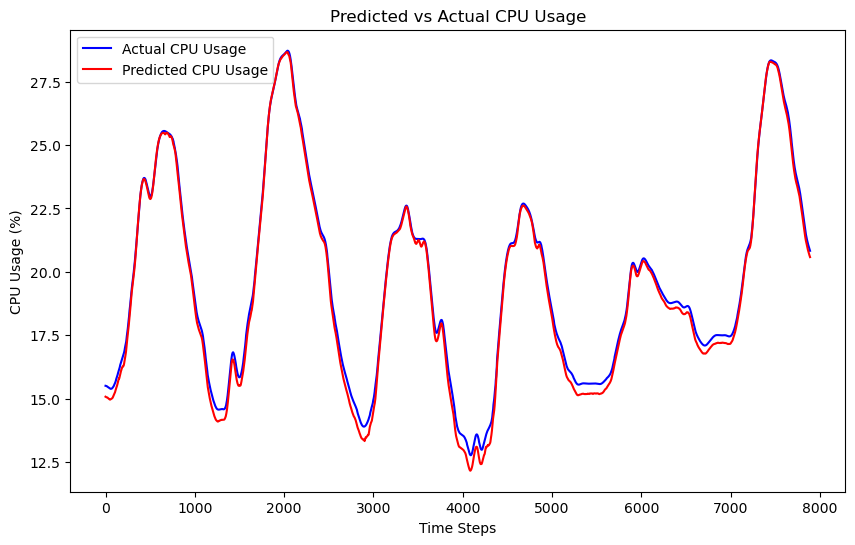

In [3]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Rescale the predicted and actual values back to the original scale (only for the target column)
# The last column of the scaler is for the CPU usage, so we need to reverse-scale it
cpu_usage_scaler = MinMaxScaler()
cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

y_test_rescaled = cpu_usage_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = cpu_usage_scaler.inverse_transform(predictions)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual CPU Usage', color='blue')
plt.plot(predictions_rescaled, label='Predicted CPU Usage', color='red')
plt.title('Predicted vs Actual CPU Usage')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()



Epoch 1/5
493/493 [==============================] - 129s 237ms/step - loss: 0.0070 - val_loss: 4.7478e-04
Epoch 2/5
493/493 [==============================] - 131s 266ms/step - loss: 0.0018 - val_loss: 2.2944e-04
Epoch 3/5
493/493 [==============================] - 194s 393ms/step - loss: 0.0011 - val_loss: 3.7485e-04
Epoch 4/5
493/493 [==============================] - 192s 389ms/step - loss: 7.1120e-04 - val_loss: 1.9427e-04
Epoch 5/5
247/247 [==============================] - 24s 96ms/step - loss: 2.3074e-04
Test MSE: 0.00023074322962202132
247/247 [==============================] - 33s 101ms/step


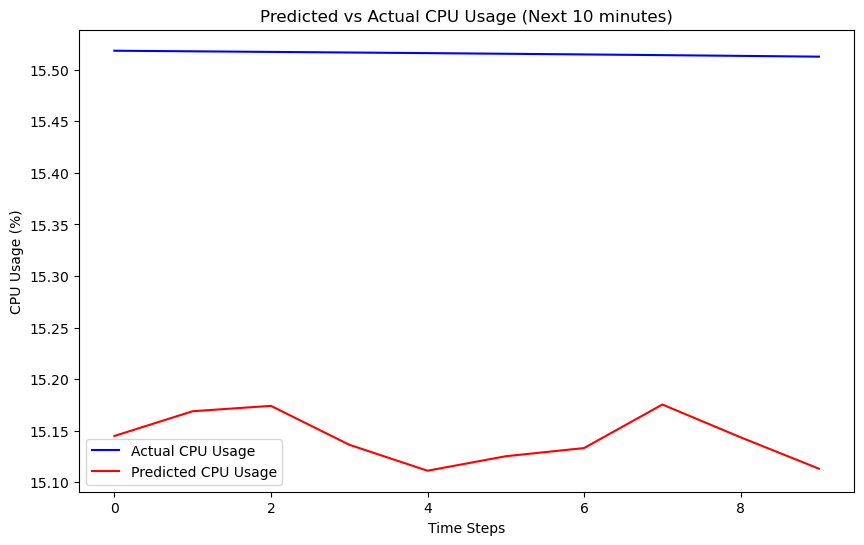

In [5]:
# Prepare the data for multi-step prediction
def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# Define the prediction length (e.g., predict the next 10 minutes = 10 data points)
prediction_steps = 10

# Create sequences for multi-step prediction
X, y = create_sequences_multi_step(scaled_data, 60, pred_steps=prediction_steps)

# Adjust train/test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Output shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Build the LSTM model for multi-step prediction
model = Sequential()

# First LSTM layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer: Predict multiple steps (next 10 minutes)
model.add(Dense(prediction_steps))  # Outputting 10 future values

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")

# Make predictions for the next 10 minutes (10 time steps)
predictions = model.predict(X_test)

# Rescale the predicted and actual values
y_test_rescaled = cpu_usage_scaler.inverse_transform(y_test)
predictions_rescaled = cpu_usage_scaler.inverse_transform(predictions)

# Plot the actual vs predicted values (for one example)
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[0], label='Actual CPU Usage', color='blue')
plt.plot(predictions_rescaled[0], label='Predicted CPU Usage', color='red')
plt.title('Predicted vs Actual CPU Usage (Next 10 minutes)')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()
